In [1]:
import pandas as pd
import scipy
import numpy as np
from scipy import stats, special

import tensorflow as tf
print(tf.__version__)
sess = tf.InteractiveSession()

import tfnb

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import gc

1.2.0


# Hyperparameters

In [2]:
N_z = 20  # Latent variables, split evenly between sites & observers
N_h = 50 # Neurons in non-final hidden layer(s)
N_bottleneck = 10 # Neurons in final hidden layer
N_reps = 1

# Data

In [3]:
# Data
x_array = np.array(pd.read_csv("x.csv"))
y_array = np.array(pd.read_csv("y.csv"))
site_array = (np.array(pd.read_csv("site.csv"))) - 1 # Zero-indexing versus R's one-indexing
obs_array = (np.array(pd.read_csv("obs.csv"))) - 1   # Zero-indexing

# Sizes
N_x = x_array.shape[1]
N_y = y_array.shape[1]

N_s = int(np.max(site_array[:,1])) + 1 # Include zero as a column
N_o = int(np.max(obs_array[:,1])) + 1  # Include zero as a column
N_rows = x_array.shape[0]

N = tf.placeholder(tf.int32, shape=[], name = "rows") # Minibatch size
Y = tf.placeholder(tf.float32, shape=[None, N_y], name = "abundance") # Response variables
X = tf.placeholder(tf.float32, shape=[None, N_x], name = "environment") # Predictor variables
S = tf.placeholder(tf.int32, shape=[None], name = "Site-ID") # site index
O = tf.placeholder(tf.int32, shape=[None], name = "Observer-ID") # observer index

# Neural network

### Layer 0: Latent random variables

In [5]:
with tf.variable_scope("latent-params"):
    # Full data set
    half_N_z = int(N_z/2)
    site_mu = tf.Variable(tf.random_normal([N_s, N_z]) * tf.sqrt(0.1))
    obs_mu = tf.Variable(tf.random_normal([N_o, N_z]) * tf.sqrt(0.1))
    site_sigma = tf.Variable(tf.ones([N_s, N_z]))
    obs_sigma = tf.Variable(tf.ones([N_o, N_z]))
    
    # Mean and standard deviation of "mu" and "sigma" in a given minibatch
    mu0 = tf.add(tf.gather(site_mu, S), tf.gather(obs_mu, O), name="mu")
    sigma0 = tf.sqrt(tf.add(tf.square(tf.gather(site_sigma,S)), tf.square(tf.gather(obs_sigma, O))), name = "sigma")

with tf.variable_scope("latent-random"):
    epsilon = tf.random_normal([N, N_z])
    Z = tf.add(mu0, sigma0 * epsilon, name = "Z")
    
# Define layer 1's inputs with X and Z
XZ = tf.concat([X, Z], 1)

### Hidden layers

In [6]:
H1 = tf.layers.dense(XZ, 
                     units=N_h, 
                     activation=tf.nn.elu,
                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                     kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01),
                     name="layer1")
H2 = tf.layers.dense(H1, 
                     units=N_bottleneck, 
                     activation=tf.nn.elu,
                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                     kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01),
                     name="layer2")
HN = H2

### Output layer

In [7]:
with tf.variable_scope("squared-distance",reuse=False):
    niche_optima = tf.Variable(tf.random_normal((N_bottleneck, N_y), stddev=.1),name="optima",
                           dtype=tf.float32)
    niche_widths = tf.Variable(tf.fill([N_bottleneck, N_y], 5.0), name="scales", 
                            dtype=tf.float32)
    d_squared = tf.transpose(
                    tf.map_fn(lambda i: 
                      tf.reduce_sum(tf.squared_difference(HN, niche_optima[:,i]) / tf.square(niche_widths[:,i]), 
                                    axis=1), 
                      np.arange(N_y, dtype=np.int32),
                      dtype=tf.float32))

In [8]:
with tf.variable_scope("negative-binomial",reuse=False):
    # Scaled radial basis function plus a small fudge-factor
    # The scaling has two parts: the first normalizes the density, and the second
    # rescales the niche peak to a reasonable height
    log_normalizer = .5 * N_bottleneck * tf.log(2 * np.pi) + tf.log(tf.reduce_prod(niche_widths, axis=0))
    log_multiplier = tf.Variable(1 + np.log(np.mean(y_array, axis=0)) + log_normalizer, 
                                 dtype=tf.float32)
    nb_mu = tf.exp(-0.5 * d_squared - log_normalizer + log_multiplier) + 1E-6
    nb_size_raw = tf.Variable(tf.ones(N_y))
    nb_size = tf.exp(nb_size_raw) + 1

    # Zero-inflation
    zi_p_raw = tf.Variable(tf.zeros_like(nb_size))
    zi_p = tf.sigmoid(zi_p_raw)

    # Switch to N,p parameterization for negative binomial
    nb_p = nb_size / (nb_mu + nb_size)

# Loss & Optimizer

In [9]:
with tf.variable_scope("losses",reuse=False):
    prediction_loss = -tf.reduce_sum(tfnb.zi_nbinom_ll(Y, nb_size, nb_p, zi_p))

    # Put a prior on negative binomial's "p" and the zero-inflation parameter, 
    # which both cause numerical problems at 0 or 1
    prior_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

    variational_loss = tfnb.kl(tf.gather(site_mu, S), tf.gather(site_sigma, S)) + \
                                tfnb.kl(tf.gather(obs_mu, O), tf.gather(obs_sigma, O))

    loss = prediction_loss + prior_loss + variational_loss

adam = tf.train.AdamOptimizer();
train_step = adam.minimize(loss);

# Stuff for fitting loop

In [10]:
# Session incantations 
init = tf.global_variables_initializer()

# Save output for tensorboard
#train_writer = tf.summary.FileWriter('./train', sess.graph)
#train_writer.close()

In [12]:
sess.run(init)

In [24]:
rows = np.arange(y_array.shape[0])
n_steps = 0.
t = tf.placeholder(dtype=tf.float32)

class minibatcher(object):
    def __init__(self, nrow):
        self.nrow = nrow
        self.epochs = 0
        self.pointer = 0
        self.order = np.arange(nrow)
        np.random.shuffle(self.order)
        #self.print_status()
    def get_rows(self, n):
        if (n+self.pointer < self.nrow):
            out = self.order[self.pointer + np.arange(n)]
            self.pointer += n
            return out
        else:
            # This is suboptimal because it throws out anything at the end
            # of the epoch that doesn't divide evenly into `n`
            np.random.shuffle(self.order)
            self.pointer = 0
            self.epochs += 1
            self.print_loss()
            return self.get_rows(n)
    def print_loss(self):
        raw_losses = sess.run([prediction_loss, prior_loss, variational_loss, loss], 
                              feed_dict=full_feed())
        loss_list = [loss / N_rows for loss in raw_losses]
        print(np.round(loss_list, 4))
        return loss_list

def make_minibatch(n):
    if n==N_rows:
        rows = np.arange(N_rows)
    else:
        rows = np.repeat(mb.get_rows(n), N_reps)
    
    return {X:x_array[rows,:], 
            Y:y_array[rows,:], 
            S:site_array[rows,1],
            O:obs_array[rows,1],
            N:len(rows)}
def full_feed():
    return make_minibatch(N_rows)

mb = minibatcher(N_rows)

In [22]:
#tf.train.shuffle_batch((x_array, y_array, site_array, obs_array),
#                       16,
#                       capacity = x_array.shape[0],
#                       min_after_dequeue = 1000,
#                       enqueue_many = True)

# Model-fitting loop

In [ ]:
# Fit the model
n = 16

for i in range(1000000):
    sess.run(train_step, feed_dict=make_minibatch(n))
    n_steps += 1

[  2.01354500e+02   1.00000000e-04   5.21180000e+00   2.06566400e+02]
[  2.01276600e+02   1.00000000e-04   5.21560000e+00   2.06492300e+02]
[  2.01215600e+02   1.00000000e-04   5.22090000e+00   2.06436600e+02]
[  2.01099800e+02   1.00000000e-04   5.21170000e+00   2.06311500e+02]
[  2.01219700e+02   1.00000000e-04   5.22790000e+00   2.06447600e+02]
[  2.01163700e+02   1.00000000e-04   5.23610000e+00   2.06399800e+02]
[  2.00979300e+02   1.00000000e-04   5.23800000e+00   2.06217400e+02]
[  2.01024200e+02   1.00000000e-04   5.25280000e+00   2.06277000e+02]
[  2.01009900e+02   1.00000000e-04   5.25720000e+00   2.06267100e+02]
[  2.01328100e+02   1.00000000e-04   5.26510000e+00   2.06593300e+02]
[  2.01049900e+02   1.00000000e-04   5.25910000e+00   2.06309100e+02]
[  2.01029800e+02   1.00000000e-04   5.25060000e+00   2.06280400e+02]
[  2.00935900e+02   1.00000000e-04   5.26080000e+00   2.06196700e+02]
[  2.00974100e+02   1.00000000e-04   5.26240000e+00   2.06236600e+02]
[  2.01411400e+02   

# Downstream analyses

In [26]:
print(n_steps)
print(mb.epochs)
mb.print_loss();

204386.0
112
[  2.01148400e+02   1.00000000e-04   5.21720000e+00   2.06365600e+02]


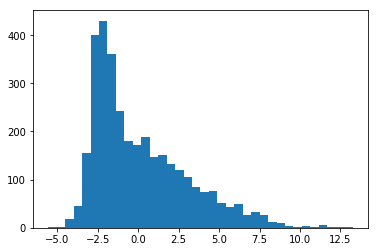

In [27]:
plt.hist(sess.run(niche_optima, feed_dict=make_minibatch(1000)).flatten(), bins="fd");

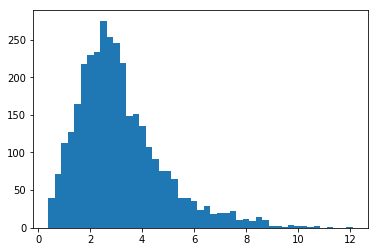

In [28]:
plt.hist(sess.run(niche_widths, feed_dict=make_minibatch(1000)).flatten(), bins="fd");

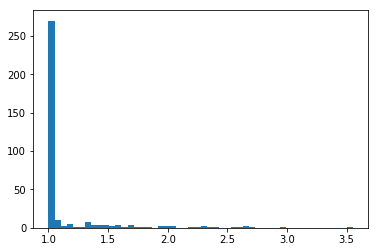

In [29]:
plt.hist(sess.run(nb_size, feed_dict=make_minibatch(1000)).flatten(), bins=50);

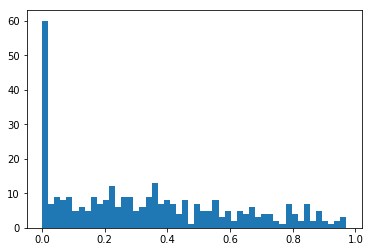

In [30]:
plt.hist(sess.run(zi_p, feed_dict=make_minibatch(1000)).flatten(), bins=50);

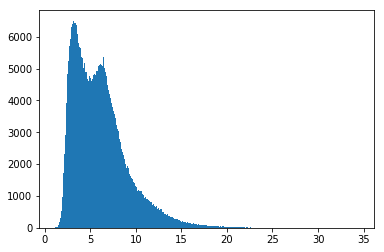

In [45]:
plt.hist(sess.run(tf.sqrt(d_squared), feed_dict=make_minibatch(1000)).flatten(), bins="fd");

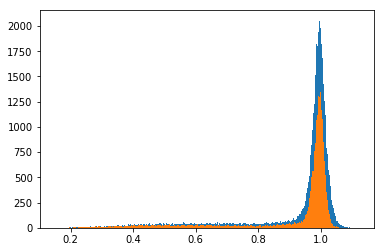

In [32]:
plt.hist(sess.run(obs_sigma).flatten(), bins = "fd");
plt.hist(sess.run(site_sigma).flatten(), bins = "fd");

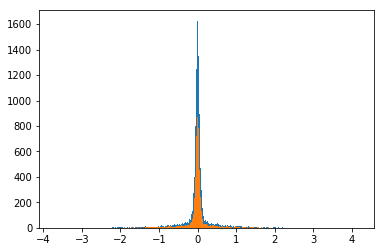

In [33]:
plt.hist(sess.run(obs_mu).flatten(), bins = "fd");
plt.hist(sess.run(site_mu).flatten(), bins = "fd");

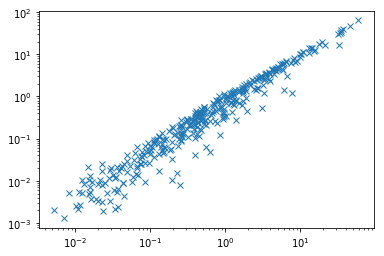

In [34]:
plt.loglog(sess.run(tf.reduce_mean(nb_mu, axis=0), feed_dict=make_minibatch(1000)),
           np.mean(y_array, axis=0), marker='x', linestyle='None');

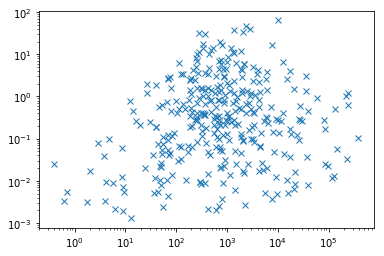

In [35]:
plt.loglog(sess.run(tf.exp(log_multiplier - log_normalizer)),
           np.mean(y_array, axis=0), marker='x', linestyle='None');

In [36]:
mus, losses = sess.run((nb_mu, tfnb.zi_nbinom_ll(Y, nb_size, nb_p, zi_p)), feed_dict=full_feed())

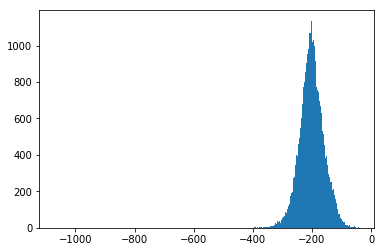

In [37]:
plt.hist(np.sum(losses, axis=1), bins = "fd");

In [38]:
hn = sess.run(HN, feed_dict=full_feed())
np.std(hn, axis=0)

array([ 2.37808537,  2.46172285,  2.39964914,  2.18467021,  2.89635754,
        2.18670678,  2.42583752,  2.67309856,  2.0411489 ,  2.54714012], dtype=float32)

In [47]:
print(1-np.mean(sess.run(obs_sigma)**2))
print(1-np.mean(sess.run(site_sigma)**2))

0.120546340942
0.137709319592
